# Sales Forecasting

The analysis was conducted to determine the sales forecast in the next 5 years. The data used is a superstore dataset, containing sales data from 2014 to 2017. Forecasting is done based on sales history, not forecasting based on certain variables.
The steps taken for forecasting are:
1. Pre-Processing Data
2. Visualizing and Analyzing Time Series Data
3. Check Stationarity
4. Comparing Multiple Models
5. Evaluating the Best Model
6. Forecasting

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [2]:
df = pd.read_excel('salesdata.xls')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.groupby(['Category']).size()

Category
Furniture          2121
Office Supplies    6026
Technology         1847
dtype: int64

In [4]:
df.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

## Pre-Processing Data

The data needs to be pre-processed before we use it to forecast. The processes include choosing a certain category, checking missing value, and transforming data into monthly basis. We will use the office supplies category and use daily average sales as sales value per month. 

In [5]:
#select certain category for forecasting
office = df.loc[df['Category']=='Office Supplies']
office_sales = office[['Order Date', 'Sales']]

In [6]:
#check missing value
office_sales.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
#group sales by date
office_sales = office_sales.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
#index by order date
office_sales = office_sales.set_index(['Order Date'])

In [9]:
#aggregate by month using average daily sales
monthdata = office_sales['Sales'].resample('MS').mean()

In [10]:
monthdata.head(12)

Order Date
2014-01-01     285.357647
2014-02-01      63.042588
2014-03-01     391.176318
2014-04-01     464.794750
2014-05-01     324.346545
2014-06-01     588.774409
2014-07-01     756.060400
2014-08-01     541.879143
2014-09-01    1015.677704
2014-10-01     267.078815
2014-11-01     959.372714
2014-12-01     692.556231
Freq: MS, Name: Sales, dtype: float64

## Visualizing Time Series Data

We want to see the sales graph and check if there is seasonality, trend, cycle, or any pattern in the data by decomposing the data.

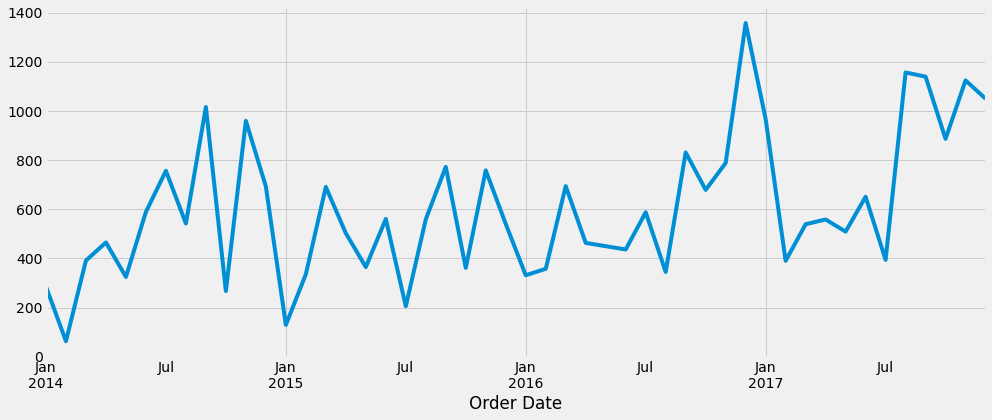

In [11]:
#using monthdata (from january 2014 until december 2017)
monthdata.plot(kind='line', figsize=(15, 6))
plt.show()

There is upward trend each year, indicated by low sales at the beginning and high at the end of the year. 

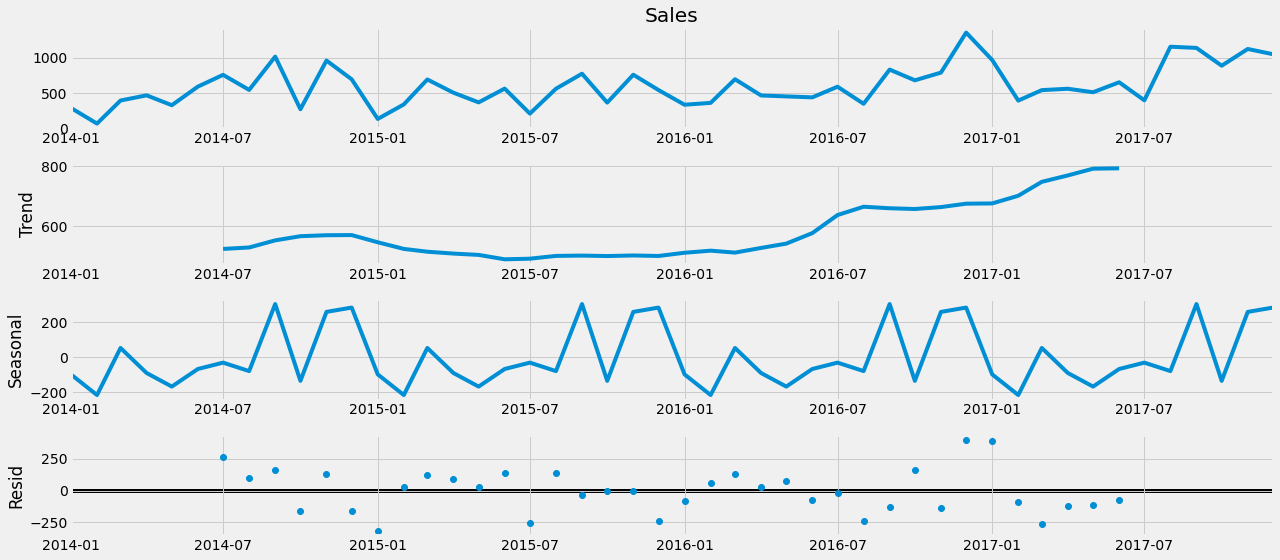

In [12]:
#Time Series Decomposition (to see if the data has seasonality, trend, and noise)
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthdata, model='additive')
fig = decomposition.plot()
plt.show()

The plot shows that monthly sales data have upward trend and strong seasonality for each year.

## Check Stationarity

Before we do further analysis and forecasting, we need to ensure that the data is stationary. We have to use stationary data for forecasting. To see whether the data is stationary or not, we can see the rolling statistics (mean and standard deviation) for the data, compare it with rolling statistics for de-trended data and differenced data. We can also run the ADF test to check stationarity.

In [40]:
#rolling statistics
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

monthdata_copy['z_data'] = (monthdata_copy['Sales'] - monthdata_copy.Sales.rolling(window=12).mean()) / monthdata_copy.Sales.rolling(window=12).std()
monthdata_copy['zp_data'] = monthdata_copy['z_data'] - monthdata_copy['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.Sales, label='raw data')
    ax[0].plot(df.Sales.rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df.Sales.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

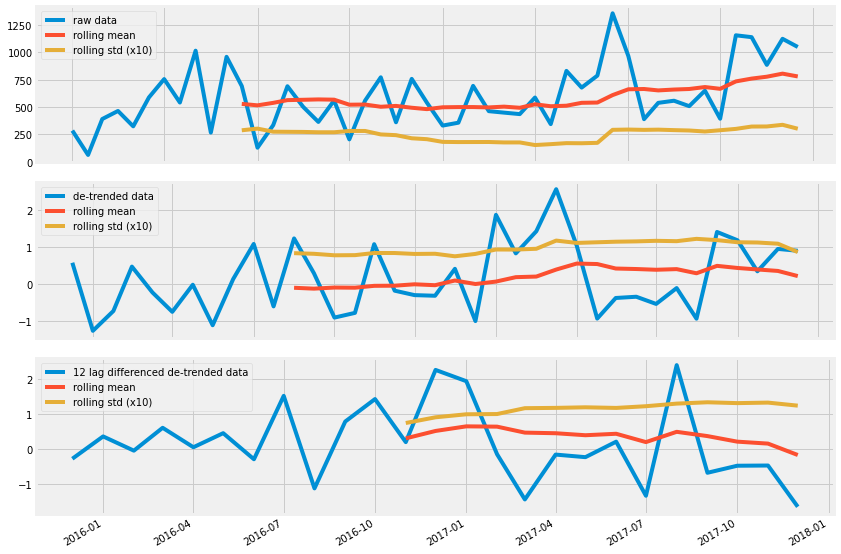

In [41]:
plot_rolling(monthdata_copy)

In [90]:
# to Check series is stationary or not with ADF
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [37]:
monthdata_copy.head()

,Sales,EWMA4,SES4,DESadd4
Order Date,,,,
2014-01-01,285.357647,285.357647,285.357647,333.316767
2014-02-01,63.042588,196.431624,196.431624,186.939675
2014-03-01,391.176318,274.329501,274.329501,340.756701
2014-04-01,464.794750,350.515601,350.515601,458.848774
2014-05-01,324.346545,340.047979,340.047979,411.179484


In [94]:
adf_test(monthdata_copy['Sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.664633
p-value                  0.000098
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


From rolling statistics for de-trended and differenced data, we know that the data is already stationary. Also, from ADF test we can conclude that the data is having stationarity and ready to forecast.

## Forecasting (ARIMA)

For forecasting, we know that the data is stationary we can use ARIMA model. We will automate parameter optimization using grid search.

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [14]:
#parameter selection using grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthdata,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
#result: ARIMA(0, 1, 1)x(0, 1, 1, 12)12

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:762.2281447919565


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2425.6283226944165
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:514.2453781966171
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:513.1792142134639
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:706.4393992780622


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1935.2921515893095
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:513.3432763125356
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:515.1590780512083
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:731.7028563444485


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2192.847803217614
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:515.5016070404582
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:512.7636627370301
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:702.5123922719906


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2317.9977188473017
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:512.3946157606829
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:514.3326678379728
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:680.3485938714521


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1743.9215290360978
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:518.068631301772
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:508.9035131483899
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:680.158244978913


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1919.3135853826877
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:508.1873970364823
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:509.7064542538287
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:664.9614866322476


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2148.72766103255
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:502.1501810460798
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:496.07011998088547
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:662.182823441869


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2165.8053158640655
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:497.5151776631887
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:498.066339230307
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:695.5204665663624


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2013.5865227611562
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:515.2555265281012
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:511.7789825740463
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:692.4887706648898


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1642.249006269908
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:511.2925670409965
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:513.1764440198656
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:682.8122268106373


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1985.1081815395298
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:516.1144290513442
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:510.32133540554213
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:679.9732892588063


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2272.47620042403
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:511.78179134665186


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:512.3159826919119
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.9023647022647


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2296.0626316275425
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:509.5708430712527
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:502.08940582007097
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:670.480965016048


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1819.7923077790686
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:503.84863493261537
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:503.8027924983223
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:666.5991687057443


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1993.798980141385
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:504.1442838455042
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:497.67788471246564
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:663.7162584548523


c:\users\bianda\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1694.050652379949
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:498.788064710055
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:499.6369881690582


In [15]:
#fitting ARIMA model
mod = sm.tsa.statespace.SARIMAX(monthdata,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8436      0.117     -7.239      0.000      -1.072      -0.615
ma.S.L12      -1.0001      0.201     -4.978      0.000      -1.394      -0.606
sigma2      4.502e+04   4.46e-06   1.01e+10      0.000     4.5e+04     4.5e+04


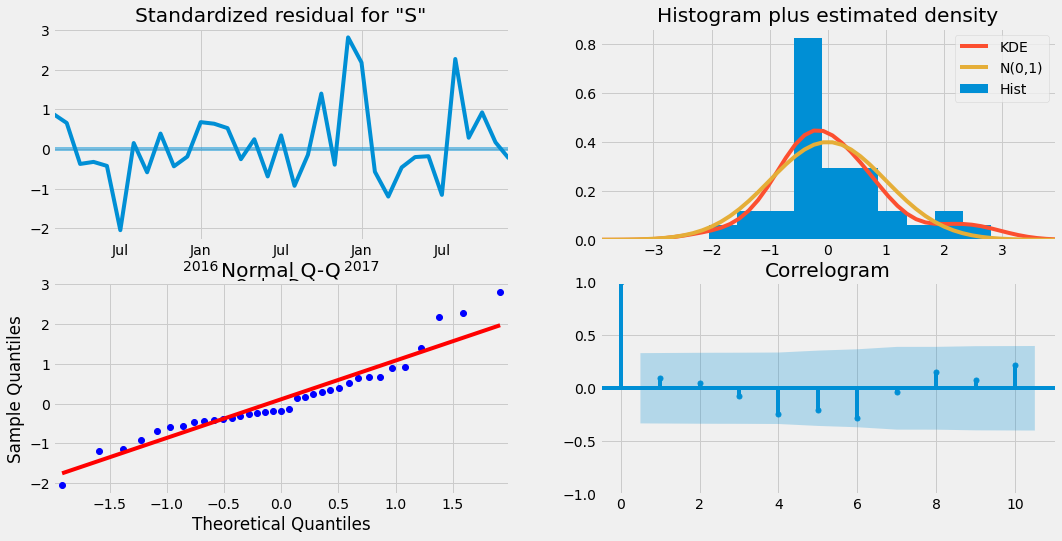

In [16]:
#run model diagnostic
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The graphs shows that model residuals are normally distributed

## Model Validation

From the model, we know that ARIMA(0, 1, 1)(0, 1, 1, 12)12 is the best, so we will evaluate this model using 2017 data and compare with actual data to get the error.

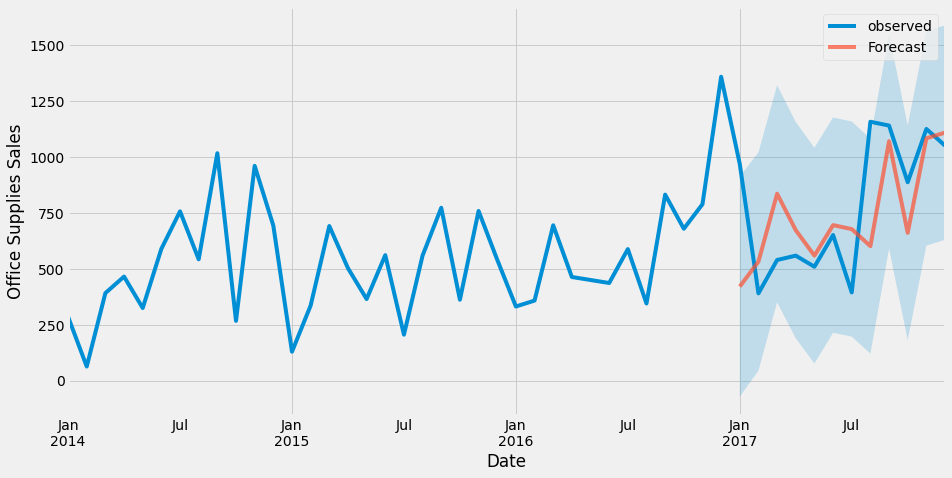

In [17]:
#predict for 2017, compare actual and forecast data
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = monthdata['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

In [18]:
#count MSE
month_forecast = pred.predicted_mean
month_real = monthdata['2017-01-01':]
mse = ((month_forecast - month_real) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

#count RMSE
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 72799.17
The Root Mean Squared Error of our forecasts is 269.81


In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -245.035
Date:                            Tue, 17 Aug 2021   AIC                            496.070
Time:                                    10:57:12   BIC                            500.736
Sample:                                01-01-2014   HQIC                           497.681
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8436      0.117     -7.239      0.000      -1.072      -0.615
ma.S.L12      -1.0001      0.201     -4.978      0.000      -1.394      -0.606
sigma2      4.502e+04   4.46e-06   1.01e+10      0.000     4.5e+04     4.5e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 5.07
Prob(Q):                              0.55   Prob(JB):                         0.08
Heteroskedasticity (H):               2.04   Skew:                             0.78
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+25. Standard errors may be unstable.
"""

## Forecast for next 5 years

The ARIMA model is fit to use in stationary data. The RMSE of the ARIMA model is around 200, so we can accept this (because the range of the data is varying from 200 -1250) and use the model to forecast sales from 2018 to 2022.

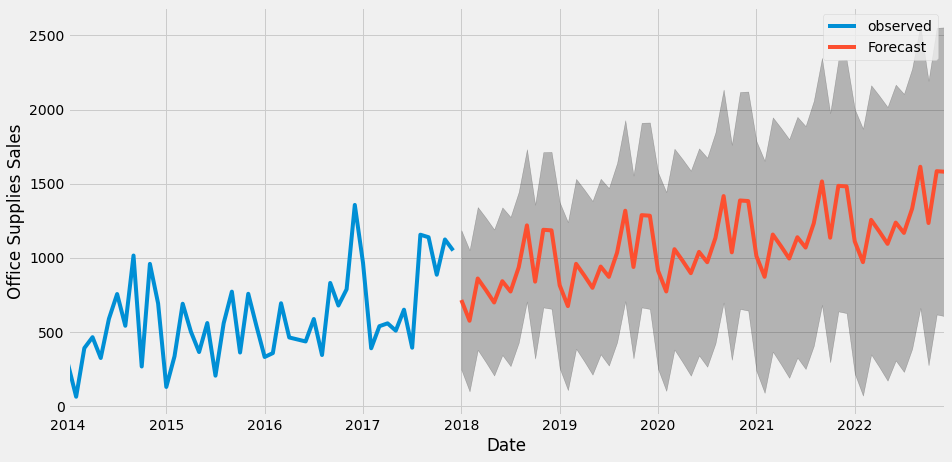

In [20]:
pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = monthdata.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

## Weighted MA, Exponential Smoothing, Double Exponential Smoothing

What if we use another method to forecast sales data as a comparison? For the next section, we will forecast the data using weighted moving average, exponential smoothing, and double exponential smoothing. 

In [21]:
monthdata_copy = monthdata.copy()
monthdata_copy = pd.DataFrame(monthdata_copy)

In [22]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

span = 4
alpha = 2/(span+1)
# Simple Weighted Moving Average
monthdata_copy['EWMA4'] = monthdata_copy['Sales'].ewm(alpha=alpha,adjust=False).mean() 

# Simple Exponentional Smoothing
monthdata_copy['SES4']=SimpleExpSmoothing(monthdata_copy['Sales']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

#Double Exponentional  Smothening
monthdata_copy['DESadd4'] = ExponentialSmoothing(monthdata_copy['Sales'], trend='add').fit().fittedvalues.shift(-1)

<AxesSubplot:xlabel='Order Date'>

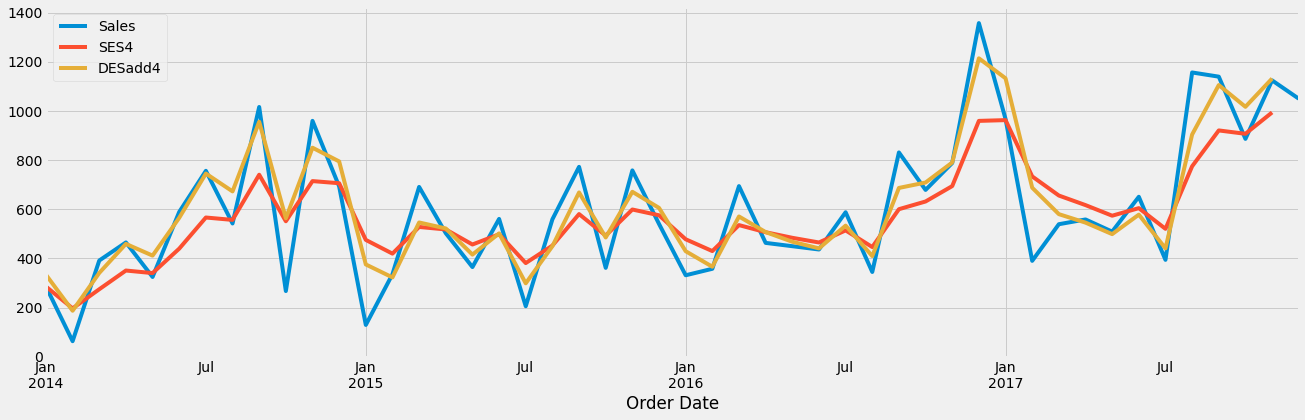

In [23]:
monthdata_copy[["Sales",'SES4','DESadd4']].plot(figsize = (20,6))

In [24]:
#count MSE DESadd4
mse = ((monthdata_copy['DESadd4'] - monthdata_copy['Sales']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

#count RMSE DESadd4
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 12541.89
The Root Mean Squared Error of our forecasts is 111.99


In [25]:
#count MSE SES4
mse = ((monthdata_copy['SES4'] - monthdata_copy['Sales']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

#count RMSE SES4
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 27038.09
The Root Mean Squared Error of our forecasts is 164.43


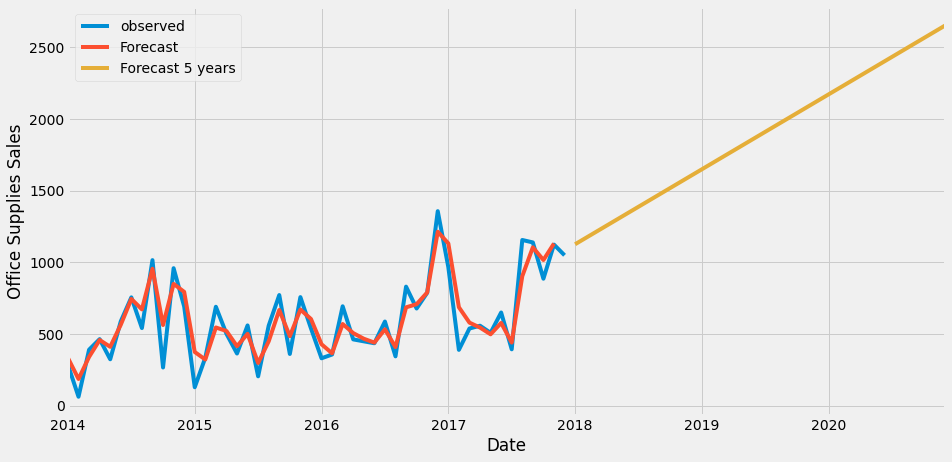

In [35]:
#predict using double exponential smoothing
fit = ExponentialSmoothing(monthdata_copy['Sales'], trend='add').fit()
fcast = fit.forecast(36)

ax = monthdata.plot(label='observed', figsize=(14, 7))
fit.fittedvalues.shift(-1).plot(ax=ax, label='Forecast')
fcast.plot(ax=ax, label='Forecast 5 years')
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

The conclusion is double exponential smoothing has the smallest RMSE. However, it can't predict the next period of time if there is seasonality in the data. We can say that this method is not suitable to use in the data.

## Using ARMA model

In the previous section we forecast using ARIMA model where the data and the seasonality differenced. For this section, we will use the actual data and see which model gives the best and least error.

Auto ARIMA

In [99]:
! pip install pmdarima 
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

  Using cached pmdarima-1.8.2-cp38-cp38-win_amd64.whl (596 kB)
  Using cached Cython-0.29.24-cp38-cp38-win_amd64.whl (1.7 MB)


You should consider upgrading via the 'c:\users\bianda\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [100]:
fit = auto_arima(monthdata_copy['Sales'], start_p=1, start_q=1,
                          max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

fit.summary()
# After running Auto Arima, Best order is ARIMA(0,0,0)(2,1,0)[12] intercept which AIC is minimum

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=513.280, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=508.813, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=514.245, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=515.063, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=509.068, Time=0.60 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=509.131, Time=0.43 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=511.130, Time=0.74 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=508.541, Time=0.23 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=507.947, Time=0.46 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=509.238, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -249.973
Date:                  Mon, 16 Aug 2021   AIC                            507.947
Time:                          21:06:21   BIC                            514.281
Sample:                               0   HQIC                           510.158
                                   - 48                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    192.5070     71.643      2.687      0.007      52.089     332.925
ar.S.L12      -0.7223      0.303     -2.382      0.017      -1.317      -0.128
ar.S.L24      -0.4120      0.259     -1.589      0.112      -0.920       0.096
sigma2      5.253e+04   1.87e+04      2.803      0.005    1.58e+04    8.93e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 5.19
Prob(Q):                              0.41   Prob(JB):                         0.07
Heteroskedasticity (H):               1.69   Skew:                             0.82
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
#fitting ARIMA model
mod = sm.tsa.statespace.SARIMAX(monthdata,
                                order=(0, 0, 0),
                                seasonal_order=(2, 1, 0, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)
hasil = mod.fit()
print(hasil.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3914      0.330     -1.187      0.235      -1.038       0.255
ar.S.L24      -0.1527      0.566     -0.270      0.787      -1.263       0.957
sigma2      7.747e+04   1.71e+04      4.527      0.000    4.39e+04    1.11e+05


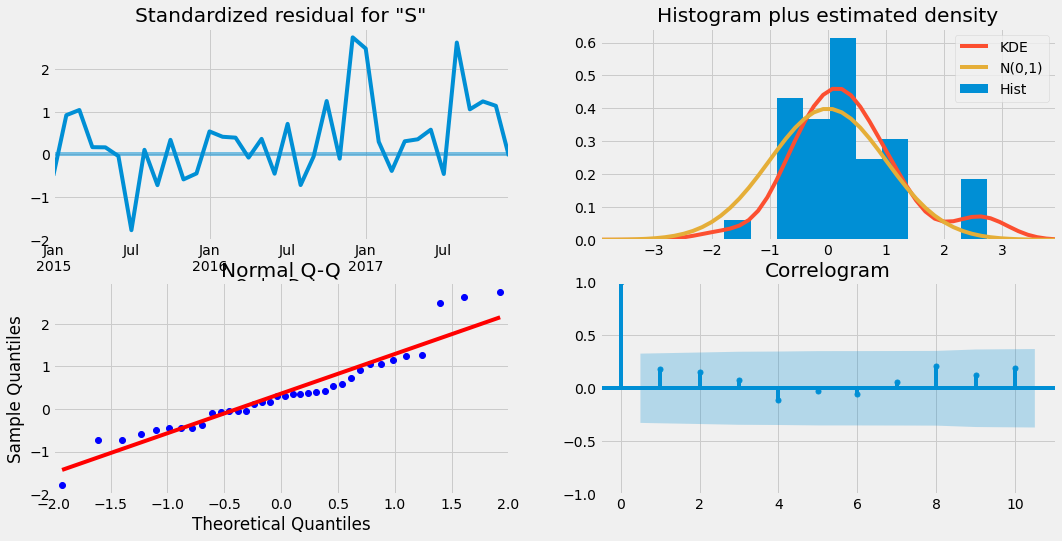

In [104]:
#run model diagnostic
hasil.plot_diagnostics(figsize=(16, 8))
plt.show()

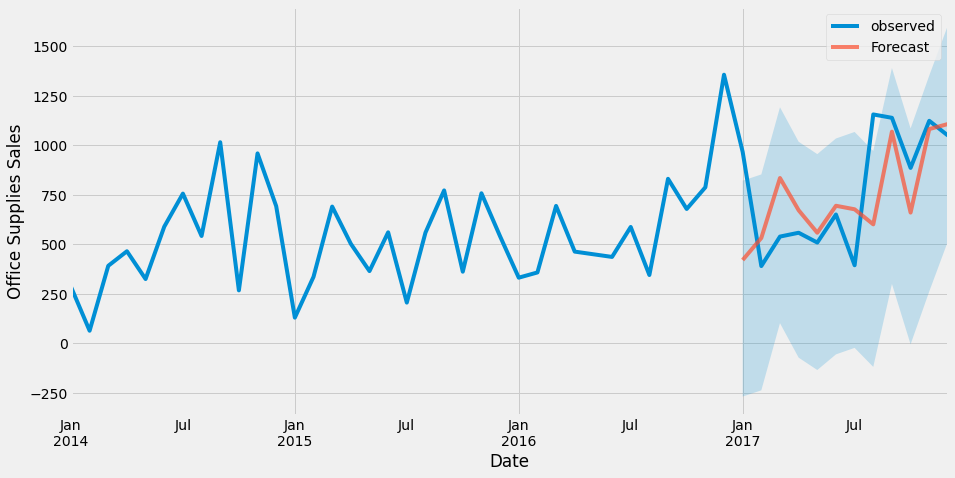

In [105]:
#predict for 2017, compare actual and forecast data
pred_2 = hasil.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci_2 = pred_2.conf_int()
ax = monthdata['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci_2.index,
                pred_ci_2.iloc[:, 0],
                pred_ci_2.iloc[:, 1], alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

In [106]:
#count MSE
month_forecast_2 = pred_2.predicted_mean
month_real = monthdata['2017-01-01':]
mse = ((month_forecast_2 - month_real) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

#count RMSE
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 116309.87
The Root Mean Squared Error of our forecasts is 341.04


ARIMA(0,0,0)(2,1,0)12 model gives slightly higher error than ARIMA(0,1,1)(0,1,1,12)12 so we will use the result from the best model to forecast sales data. The forecasting graph shows that sales data follows a trend and seasonal pattern well from historical data. 